In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/suhas/Desktop/office/Data Science/Notes/Data Analysis/Data/insurance.csv')

In [3]:
df.shape

(1338, 7)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.duplicated().sum()

1

In [6]:
df = df.drop_duplicates(keep='first')

In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

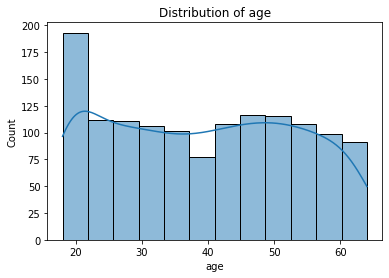

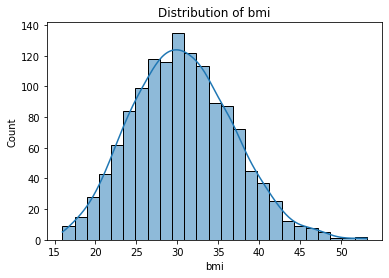

--------------------------------------------------


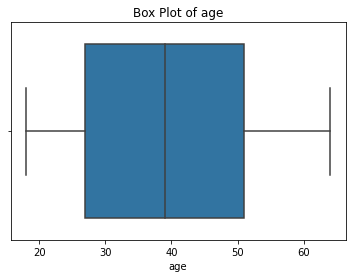

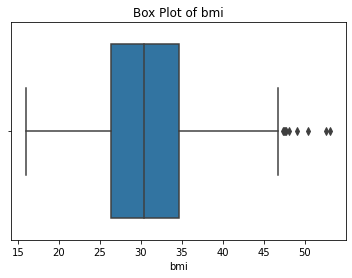

--------------------------------------------------


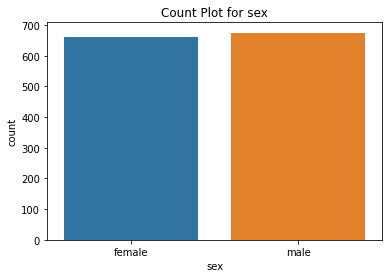

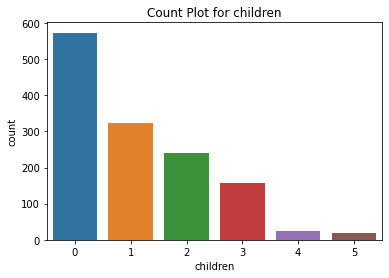

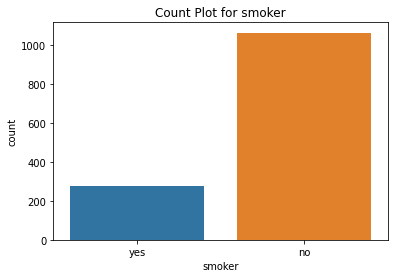

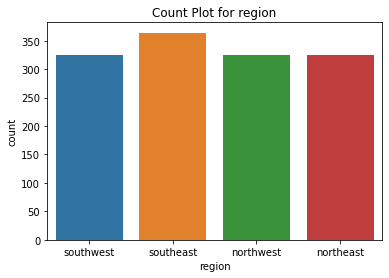

--------------------------------------------------


<AxesSubplot:xlabel='charges', ylabel='Count'>

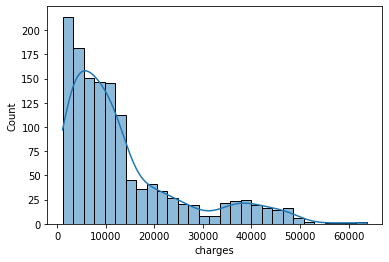

In [9]:
numerical_columns = ['age','bmi']
categorical_columns = ['sex','children','smoker','region']

for col in numerical_columns:
    sns.histplot(data=df,x=col,kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

print('-'*50)

for col in numerical_columns:
    sns.boxplot(data=df,x=col)
    plt.title(f"Box Plot of {col}")
    plt.show()

print('-'*50)

for col in categorical_columns:
    sns.countplot(data=df,x=col)
    plt.title(f"Count Plot for {col}")
    plt.show()

print('-'*50)

sns.histplot(x=df['charges'],kde=True)



In [10]:
X = df.drop(columns='charges',axis=1)
y = df['charges']

In [11]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [12]:
from sklearn.preprocessing import FunctionTransformer

fn = FunctionTransformer(np.log1p)

y = fn.fit_transform(y)

In [13]:
y.head()

0    9.734236
1    7.453882
2    8.400763
3    9.998137
4    8.260455
Name: charges, dtype: float64

In [14]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [15]:
X_train.head()

,age,sex,bmi,children,smoker,region
763,27,male,26.03,0,no,northeast
1079,63,male,33.66,3,no,southeast
178,46,female,28.90,2,no,southwest
287,63,female,26.22,0,no,northwest
1290,38,female,19.95,2,no,northeast


In [16]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,FunctionTransformer


roubust_pipeline = Pipeline([
    ('robust',RobustScaler()),
    # ('log',FunctionTransformer(np.log1p)),
    ('impute',SimpleImputer(strategy='mean')),
    ('scalar',StandardScaler())

])

categorical_piepline = Pipeline([
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(drop='first',sparse=False))
])

ordinal_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('order',OrdinalEncoder())
])



preprocess_columns = ColumnTransformer([
    ('robust',roubust_pipeline,['age','bmi']),
    ('cat',categorical_piepline,['sex','smoker','region']),
    ('order',ordinal_pipeline,['children'])
])



In [17]:
prprocess_pipeline = Pipeline([
    ('col_preprocess',preprocess_columns)
])

In [18]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import joblib
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

algorithms = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "svm": SVR(),
    "lr": LinearRegression(),
    "xg" : xgb.XGBRegressor(),
    "Adb": AdaBoostRegressor(),
    "gbs": GradientBoostingRegressor()
    
}

results = {}
pipeline_results = {}

for name,algo in algorithms.items():
    pipeline = Pipeline([
        ('process_piepline',prprocess_pipeline),
        ('algo',algo)
    ])

    pipeline.fit(X_train,y_train)

    joblib.dump(pipeline,f"{name}.pkl")
    pipeline_results[name] = pipeline

    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    ase = mean_absolute_error(y_test,y_pred)
    cv_score = cross_val_score(pipeline,X_train,y_train,scoring='r2',cv=5)
    cv_mean = cv_score.mean()

    print(f"{name}")
    print(f"R2 score: {r2}")
    print(f"MSE:{mse}")
    print(f"ASE:{ase}")
    print(f"CV:{cv_score}")
    print(f"CV Mean:{cv_mean}")
    print('-'*50)   

random_forest
R2 score: 0.8360732978086187
MSE:0.1472996900535622
ASE:0.20086448385263903
CV:[0.75768902 0.8179391  0.72915248 0.83612299 0.79867075]
CV Mean:0.7879148682493539
--------------------------------------------------
decision_tree
R2 score: 0.6782926573752859
MSE:0.28907671064627194
ASE:0.2356940903978352
CV:[0.66336523 0.66467016 0.58702926 0.53232781 0.56654818]
CV Mean:0.6027881260815745
--------------------------------------------------
svm
R2 score: 0.8747078208668146
MSE:0.11258384940183298
ASE:0.16576990140595846
CV:[0.75128533 0.83688691 0.76304236 0.84511738 0.83335276]
CV Mean:0.8059369478924625
--------------------------------------------------
lr
R2 score: 0.8238191630631833
MSE:0.15831089338863497
ASE:0.25760656550016275
CV:[0.70176539 0.75935544 0.71747375 0.7573873  0.77058502]
CV Mean:0.7413133807893427
--------------------------------------------------
xg
R2 score: 0.8040713771975374
MSE:0.17605567016001009
ASE:0.2390957056724486
CV:[0.69836024 0.7627867  0.

## Other Metrics for Regression

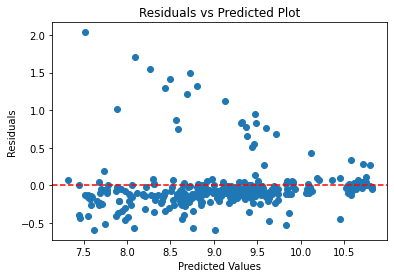

In [19]:
## Residual Analysis

residuals = y_test - y_pred


#residuals vs predicted plot
plt.scatter(y_pred,residuals)
plt.axhline(y=0,color='r',linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Plot")
plt.show()

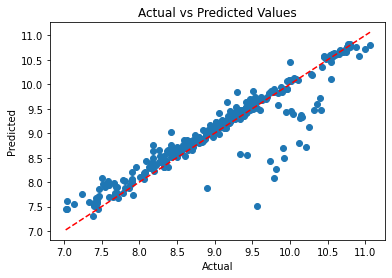

In [20]:
## Actual vs Predicted Plot

plt.scatter(y_test,y_pred)
plt.plot([y.min(),y.max()],[y.min(),y.max()],'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.show()